# Analisi dati per l'esperimento di Millikan 

Questo file è una rivisitazione corretta del file `analisi.ipynb`, che contiene tutta l'analisi dati sui dati presi in laboratorio.

Questo programma è in grado di calcolare la carica anche se i dati non sono omogenei tra loro, questo perché potrebbe capitare che una goccia acquista o perde carica durante la misura, e quindi c'è la necessità di avere un programma che sia stabile anche se manca una misura in mezzo ai dati.

## Import 

### Import delle librerie

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scienceplots

plt.style.use(["science", "grid", "ieee"])

### Import dei dati 

In [129]:
g = 9.806  # m/s^2
rho_o = 860  # kg/m^3
rho_a = 1.293  # kg/m^3
pressione = 101325 * 1.01  # Pa
b = 8.2e-3  # Pa m (costante correzione viscosa)
reticolo = 0.5 / 1000  # m

d_isolante = 7.1656 / 1000 # m

In [130]:
# settings per i dati
n_gocce = 13
n_cols = 8
n_rows = 6

# load data from excel file
data = pd.read_excel("Dati_Raccolti.xlsx", sheet_name="AllData",
                     header=None)

# drop zero rows and columns
data = data.dropna(axis=1, how="all").dropna(axis=0, how="all")

# initialize data containers
temperature = np.full(n_gocce, np.nan)
voltaggi    = np.full((n_gocce, n_cols), np.nan)
tempi       = np.full((n_gocce, n_cols, n_rows), np.nan)

# temporary variables for the loop
temp = np.full((n_rows, n_cols), np.nan) # temporary container of tempi
g_idx = -1 # index of goccia
r_idx = 0  # index of row

# loop to populate `temperature`, `voltaggi` and `tempi`
for row in data.to_numpy():
	# tempi is a row with a number and then all nan values
	if np.isnan(row[1:]).all():
		g_idx += 1
		temperature[g_idx] = row[0]

		if np.isnan(temp).all():
			continue

		tempi[g_idx - 1] = temp.T

		temp = np.full((n_rows, n_cols), np.nan)
		r_idx = 0

	# voltaggi is a row starting with zero
	elif row[0] == 0:
		voltaggi[g_idx] = row

	# tempi is everything remaining
	else:
		temp[r_idx] = row
		r_idx += 1
else:
	tempi[g_idx] = temp.T

print("Temperature [°C]:\n", temperature)
print("Voltaggi [V/m]:\n", voltaggi)
print("Tempi [s]:\n", tempi)


Temperature [°C]:
 [21. 21. 22. 22. 22. 22. 23. 23. 23. 23. 23. 23. 23.]
Voltaggi [V/m]:
 [[   0.  322.  322. -322.   nan   nan   nan   nan]
 [   0.  322. -323.  323. -323.  323. -323.  323.]
 [   0.  354.   nan   nan   nan   nan   nan   nan]
 [   0. -354.  354.   nan   nan   nan   nan   nan]
 [   0. -354.  354. -354.  354. -355.  355. -355.]
 [   0. -354.  354. -354.  354. -354.  354. -354.]
 [   0. -375.  375. -375.  375. -375.  375. -375.]
 [   0. -375.  375. -375.  375. -375.  375. -375.]
 [   0. -375.  375. -375.  375. -375.  375. -375.]
 [   0. -373.  373. -373.  373.   nan   nan   nan]
 [   0. -373.  373. -373.  373. -373.  373. -373.]
 [   0. -373.  373. -373.  373. -373.  373.   nan]
 [   0. -373.  373. -373.  373. -373.  373. -373.]]
Tempi [s]:
 [[[60.25 67.9  49.92 56.53 50.1    nan]
  [ 2.91  2.19  2.58  2.58  2.46   nan]
  [ 2.65  2.55  2.65  2.63   nan   nan]
  [ 2.73  2.26  2.81  2.79   nan   nan]
  [  nan   nan   nan   nan   nan   nan]
  [  nan   nan   nan   nan   nan  

## Analysis

Sezione di analisi dei dati raccolti, qui calcoliamo la carica e la relativa incertezza per ogni misura presa.

### Show collected data

In [131]:
plot_row = np.ceil(np.sqrt(n_gocce)).astype(int)
plot_col = np.ceil(n_gocce / plot_row).astype(int)
fig, axs = plt.subplots(plot_col, plot_row,
                        figsize=(plot_row * 4, plot_col * 3))

# TODO fare con voltaggio zero

plt.suptitle("Tempi trascorsi (con campo elettrico)")
for i in range(n_gocce):
	ax = axs[i // plot_row, i % plot_row]
	ax.set_title(f"Goccia {i + 1}")
	ax.set_xlabel("Set di misure")
	ax.set_ylabel(r"Tempo [$s$]")

	for j in range(1, n_cols):
		ax.scatter(j * np.ones(len(tempi[i, j, :n_rows])),
		           tempi[i, j, :n_rows])

plt.tight_layout()
# plt.savefig("Images/Tempi trascorsi.svg")
# plt.show()

### Funzioni utili

In [132]:
def calc_visco(t: float) -> float:
	# T deve essere in celsius
	return (1.8 + 4.765e-3 * (t - 15)) * 1e-5  # N s m^-2

In [133]:

def calc_radius(nu: float, vel: np.ndarray) -> np.ndarray:
	return np.sqrt(
			(b / (2 * pressione)) ** 2 + (9 * nu * vel) / (
					2 * g * (rho_o - rho_a))
			) - b / (2 * pressione)  # m

In [134]:
def calc_charge(r: float, v_r: float, e_field: np.ndarray, v_e: np.ndarray) \
		-> np.ndarray:
	# calcola la carica di tutti i set di una goccia
	# e_field[:, np.newaxis] rende compatibile la divisione v_e / e_field
	e_field = e_field[:, np.newaxis]
	return (-4 / 3 * np.pi * r ** 3 * (rho_o - rho_a) * g *
			(1 + np.sign(e_field) * v_e / v_r) / e_field) # C

In [135]:
def calc_stats(arr: np.ndarray):
	# 1D array
	if arr.ndim == 1:
		return np.nanmean(arr), np.nanstd(arr, ddof=1)

	# 2D array
	return np.nanmean(arr, axis=1), np.nanstd(arr, axis=1, ddof=1)

### Analisi vera e propria

In [136]:
# TODO ricontrollare questo pezzo di codice, le cariche non vanno calcolate
#  sulle mede ma per ogni valore bisogna calcolare la carica
charges = np.full((n_gocce, (n_cols - 1) * n_rows), np.nan)

for i in range(0, n_gocce):
	tempo_r_avg, tempo_r_std = calc_stats(tempi[i, 0])
	vel_r = reticolo / tempi[i, 0]
	# TODO aggiungere std

	vel_field = reticolo / tempi[i, 1:]

	# Raggio
	nu = calc_visco(temperature[i])  # ? unità di misura
	r = calc_radius(nu, vel_r)
	mean_r, std_r = np.nanmean(r), np.nanstd(r, ddof=1)
	mean_v_r, std_v_r = np.nanmean(vel_r), np.nanstd(vel_r, ddof=1)
	# TODO da fare con media pesata

	print(f"~~~~~ Goccia {i + 1} ~~~~~")
	#print(f"nu: {nu:.4g}")
	print(f"Raggio: {mean_r:.4g} ±{std_r:.2g}m")

	# Carica
	E = abs(voltaggi[i, 1:n_cols]) / d_isolante
	#print(
	#		f"Campo elettrico per set (2-{n_cols}): \n\t"
	#		+ "\n\t".join(f"{e:.3g} ±{'NOT CALCULATED'} V/m" for e in E)
	#		)

	q = calc_charge(mean_r, mean_v_r, E, vel_field).flatten()
	print(
			f"Carica e incertezza per set (2-{n_cols}): \n\t",
			q
			# add incertezza
			)
	charges[i] = q

~~~~~ Goccia 1 ~~~~~
Raggio: 2.571e-07 ±1.9e-08m
Carica e incertezza per set (2-8): 
	 [-2.70821816e-19 -3.55473973e-19 -3.03755770e-19 -3.03755770e-19
 -3.17922482e-19             nan -2.96084362e-19 -3.07172448e-19
 -2.96084362e-19 -2.98234523e-19             nan             nan
 -2.87798759e-19 -3.44876846e-19 -2.79984935e-19 -2.81896381e-19
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan]
~~~~~ Goccia 2 ~~~~~
Raggio: 5.219e-07 ±2.5e-08m
Carica e incertezza per set (2-8): 
	 [-6.92930069e-19 -7.15211304e-19 -6.81456300e-19 -6.74055470e-19
 -5.78542874e-19             nan -4.93331612e-19 -4.68808578e-19
 -4.58038648

In [137]:
plot_row = np.ceil(np.sqrt(n_gocce)).astype(int)
plot_col = np.ceil(n_gocce / plot_row).astype(int)
fig, axs = plt.subplots(plot_col, plot_row,
                        figsize=(plot_row * 4, plot_col * 3))

for i in range(n_gocce):
	x = np.linspace(1.5e-19, 1.7e-19, 500)
	y = 0
	for charge in charges[i]:
		if np.isnan(charge):
			continue
		y += np.square(x - charge / np.round(charge / x))

	n, m = i // plot_row, i % plot_row
	axs[n, m].plot(x, y)

	axs[n, m].set_title(f"Goccia {i + 1}")
	axs[n, m].set_xlabel(r"Carica $q$ [C]")
	axs[n, m].set_ylabel(r"$S(q)$ [C$^2$]")

plt.tight_layout()
plt.suptitle(r"$S(q)$ in funzione di $q$")
# plt.savefig("Images/Carica delle gocce.svg")
plt.show()

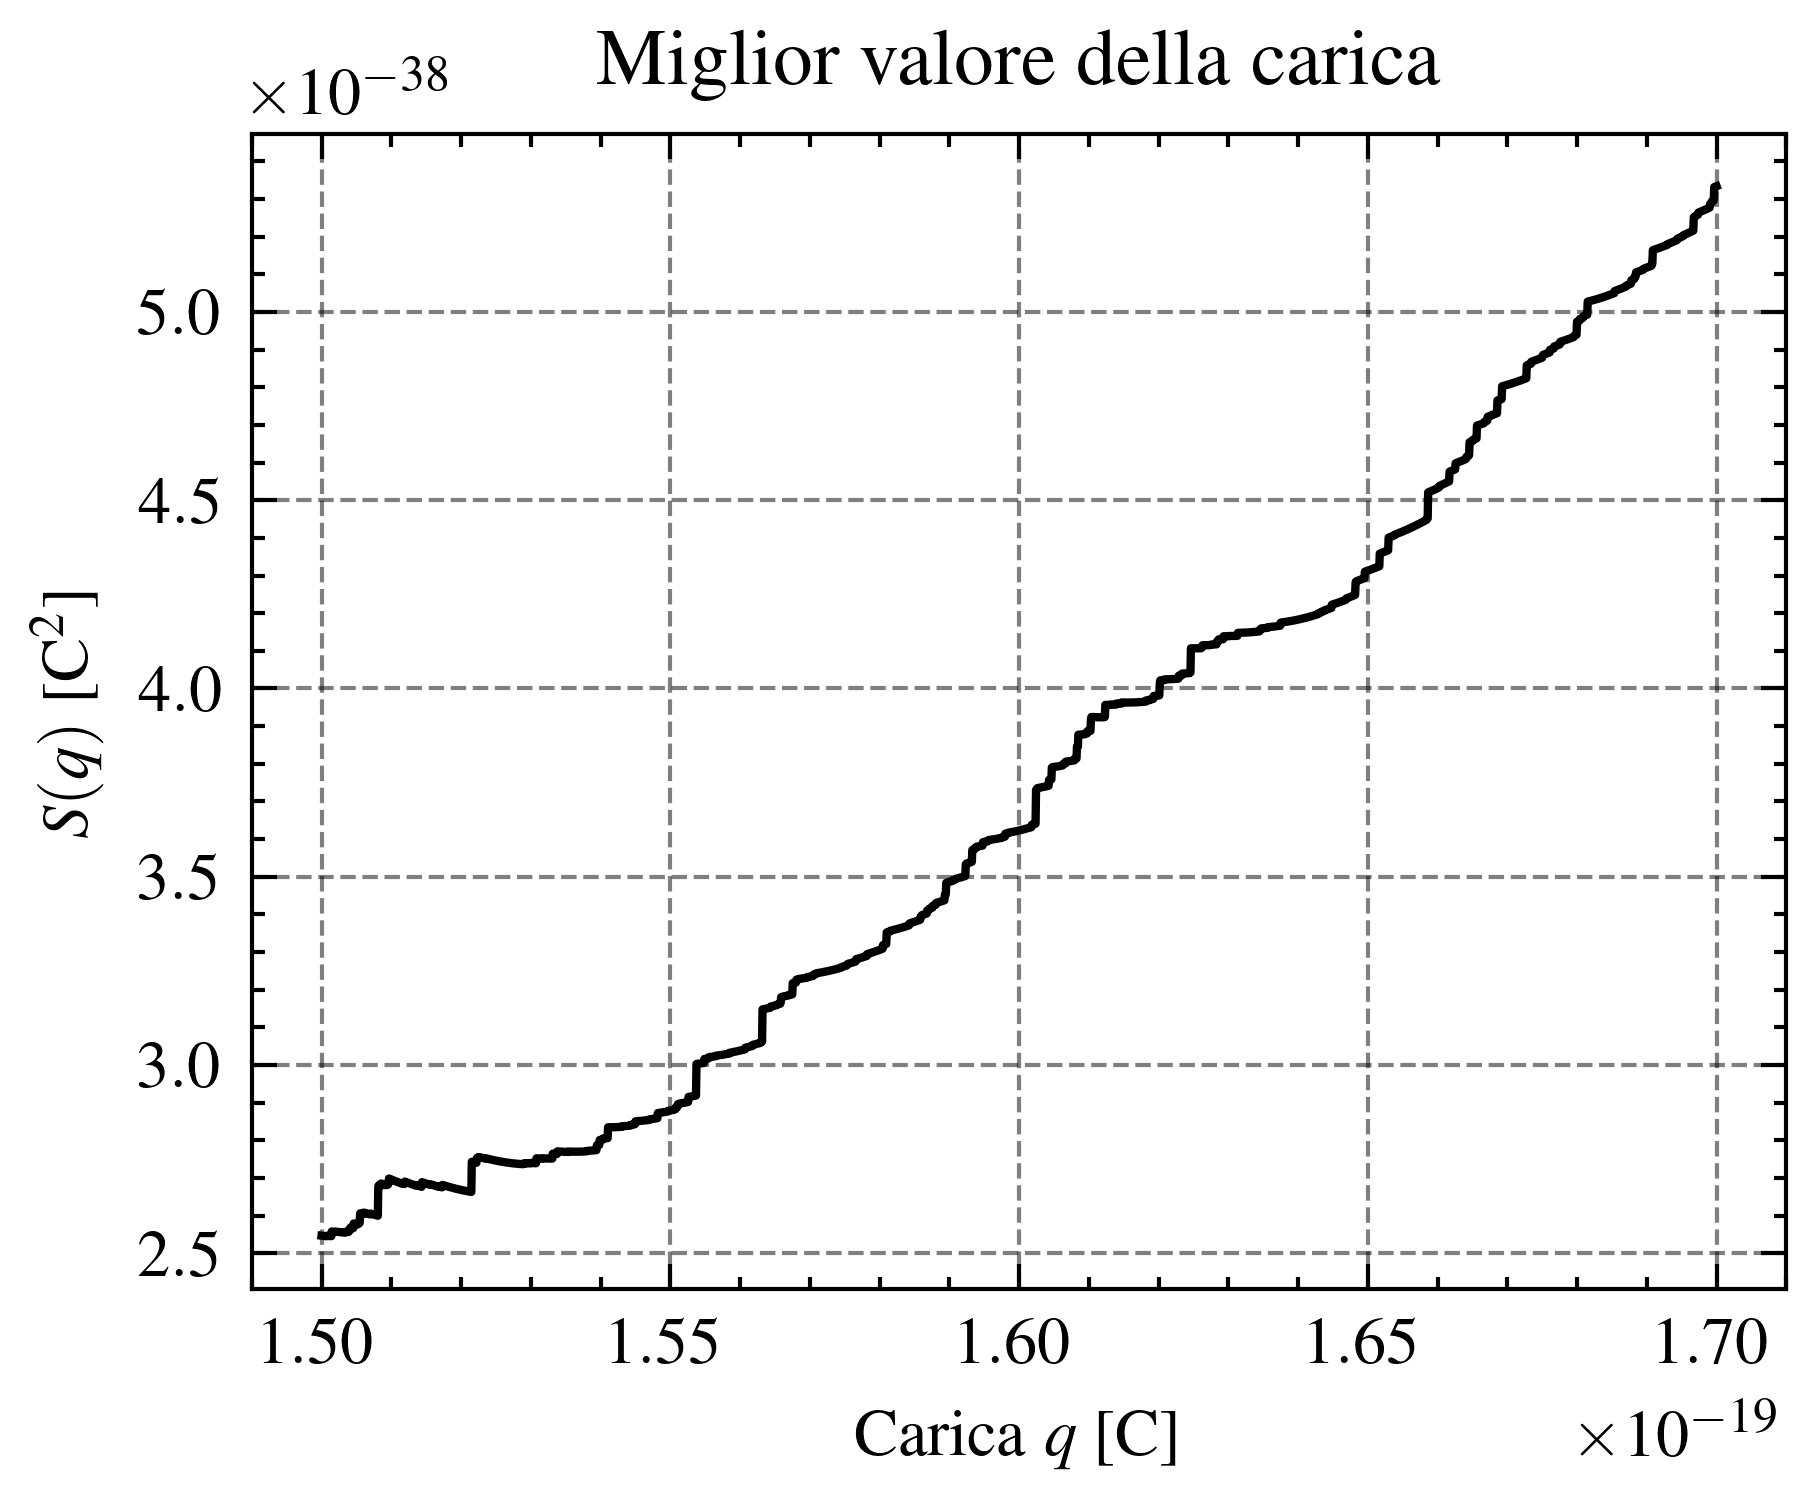

In [138]:
charges = charges.flatten()

fig, ax = plt.subplots()

x = np.linspace(1.5e-19, 1.7e-19, 3000)
y = 0
for charge in charges:
	if not np.isnan(charge):
		y += np.square(x - charge / np.round(charge / x))

plt.plot(x, y)
plt.title("Miglior valore della carica")
plt.xlabel(r"Carica $q$ [C]")
plt.ylabel(r"$S(q)$ [C$^2$]")
# plt.savefig("Images/Carica.svg")
plt.show()

In [139]:
with open("charges.txt", "w") as file:
    string = ""
    for charge in charges:
        if charge != np.nan:
            q = charge / 1.6e-19 - np.floor(charge / 1.6e-19)
            if q < 0.1 or q > 0.9:
                string += str(charge) + "\n"
            else:
                print(charge)
    file.write(string)

-2.708218159272722e-19
-3.5547397270029504e-19
-3.037557703307302e-19
-3.037557703307302e-19
nan
-2.960843620837498e-19
-2.960843620837498e-19
-2.982345232219583e-19
nan
nan
-2.877987594559279e-19
-3.4487684614261024e-19
-2.79984934913676e-19
-2.81896381239872e-19
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.929300694993123e-19
-7.152113039496609e-19
-6.814562998451554e-19
-6.740554700682317e-19
-5.785428744566133e-19
nan
-4.580386484706316e-19
-4.446490064329159e-19
nan
-6.683510517288439e-19
-6.986696439484386e-19
-6.70153977722485e-19
-6.966783804763888e-19
-6.103864599564108e-19
nan
-4.478985394420691e-19
-4.587364185486535e-19
nan
-6.756334586835506e-19
-6.793465280190094e-19
-6.888465214692639e-19
-6.683510517288439e-19
nan
nan
-6.8500865036112135e-19
-6.9273608107717945e-19
-6.683510517288439e-19
-6.774839063523694e-19
-6.774839063523694e-19
nan
-9.812389570017278e-19
-1.3545608391993138e-18
-1.259664070755264e-18
-1.